# Letter Boxed Solver

Suggests one of the best solutions for NYT letterboxed puzzles:
https://www.nytimes.com/puzzles/letter-boxed

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set your puzzle
Just type out the letters one edge at a time.

In [40]:
letters = 'yhiucsltqfad'

# Build a graph for the puzzle

These letter groupings should match the edge groups for your puzzle:
[['y', 'h', 'i'], ['u', 'c', 's'], ['l', 't', 'q'], ['f', 'a', 'd']]


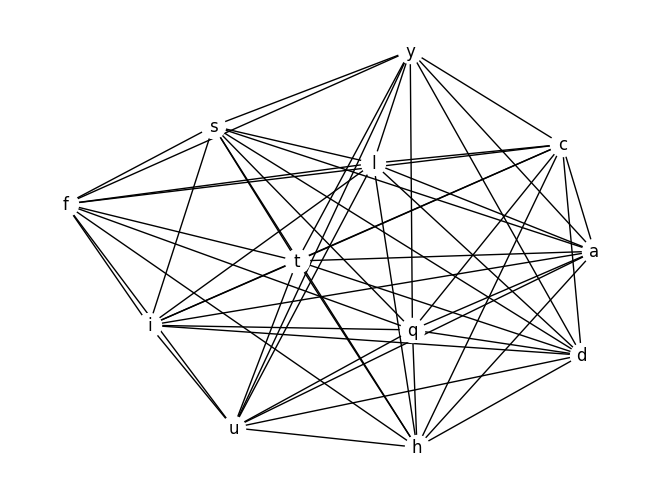

In [41]:
groups = [letters[(i*3):((i+1)*3)] for i in range(4)]
groups = [[c for c in g] for g in groups]

print('These letter groupings should match the edge groups for your puzzle:')
print(groups)

G = nx.Graph()
labels = {}

for i, ga in enumerate(groups):
    for j, gb in enumerate(groups):
        if i == j:
            continue

        for ci, ca in enumerate(ga):
            idxa = f'{i}.{ci} - {ca}'

            G.add_node(idxa)
            labels[idxa] = ca

            for cj, cb in enumerate(gb):
                idxb = f'{j}.{cj} - {cb}'
                G.add_node(idxb)
                labels[idxb] = cb

                G.add_edge(idxa, idxb)

DRAW = True
if DRAW:
    options = {
        'node_color': 'white'
    }
    nx.draw(G, with_labels=True, labels=labels, **options)
    plt.show()

# Load Dict of Words
Random word set that I downloaded from somewhere.

Letter Boxed only allows for 3-letter words, so we can filter out short ones while loading from the file here.

In [42]:
with open('words.txt') as file:
    words = [line.strip() for line in file.readlines() if len(line.strip()) >= 3]

print(len(words), words[:10])

83831 ['aachen', 'aardvark', 'aardvarks', 'aaron', 'aba', 'ababa', 'abaci', 'aback', 'abactor', 'abactors']


# Filter words by possible in network
Filter all words down to those that are possible to draw out on the given puzzle.

Pheasible words will be those that can be written out as a path on the graph that was drawn above.

In [43]:
def possible(word, labels, G):
    reverseLabels = {value: key for key, value in labels.items()}

    graphChars = set([labels[g] for g in G.nodes()])
    wordChars = set([c for c in word])
    
    charsPossible = wordChars.issubset(graphChars)
    
    if not charsPossible:
        return False
    
    
    for i in range(len(word) - 1):
        a, b = word[i], word[i+1]
        aNode = reverseLabels[a]
        bNode = reverseLabels[b]
        
        edgeExists = G.has_edge(aNode, bNode)
        if not edgeExists:
            return False
    
    return True

In [44]:
pheasibleWords = []
for word in tqdm(words):
    if possible(word, labels, G):
        pheasibleWords.append(word)

print(f'Finished with {len(pheasibleWords)} total pheasible words')

100%|█████████████████████████████████| 83831/83831 [00:00<00:00, 559794.78it/s]

Finished with 390 total pheasible words


In [45]:
pheasibleWords[:10]

['acacia',
 'acacias',
 'acid',
 'acidic',
 'acidify',
 'acidity',
 'acidly',
 'acids',
 'acquit',
 'acquits']

# Greedy algo
1. Start with the word that covers the largest possible set of letters.
2. The next best word will then be one that:
    - starts with the last letter (of previous word)
    - covers unused letters
    - is short (ranked by density of new letters over total letters in word)
3. Add the new word to the path and repeat step 2
4. End when all 12 letters have been used

**NOTE:** This implementation could get stuck and has no recursive back-out. (i.e. will chase what looks like the best solution and break if it gets stuck down an "alley").

In [46]:
def uncovered(pastWords, available):
    covered = set()
    for word in pastWords:
        for c in word:
            covered.add(c)
    
    def getRank(w):
        unused = set([c for c in w]) - covered
        return len(unused)
    
    availRanks = [(w, getRank(w)) for w in available]
    availRanks = sorted(availRanks, key=lambda x: x[-1]/len(x[0]), reverse=True)

    return availRanks

def currentCoverage(pastWords):
    covered = set()
    for word in pastWords:
        for c in word:
            covered.add(c)
    
    return len(covered)

In [47]:
def general(words):
    ranked = sorted(
        pheasibleWords,
        key=lambda w: len(set([c for c in w])),
        reverse=True
    )
    zipped = list(zip(ranked, [len(set([c for c in w])) for w in ranked]))
    print(zipped[:5])
    
    start = zipped[0][0]
    path = [start]
    
    available = ranked.copy()
    available.remove(start)
    coverage = currentCoverage(path)
    
    while coverage < 12:
        curr = path[-1]
        possible = list(filter(lambda w: w[0]==curr[-1], available))
        
        if not possible:
            print(f'BROKE AT PATH: {" -> ".join(path)} (no more next word options)')
            print(f'consider a different starting path')
            break
        
        print(f'for last word {curr} found {len(possible)} possible next steps')
        newRanks = uncovered(path, possible)
        print(f'next rankings: {newRanks[:5]}')
        
        bestWord = newRanks[0][0]
        available.remove(bestWord)
        path.append(bestWord)
        coverage = currentCoverage(path)
        print(f'new coverage: {coverage}')
        print(f'PATH: {" -> ".join(path)}')
        print()
    
    return path

In [48]:
finalPath = general(pheasibleWords)

[('disqualify', 9), ('dualistic', 8), ('squalidly', 8), ('acquits', 7), ('actuality', 7)]
for last word disqualify found 3 possible next steps
next rankings: [('yacht', 3), ('yachts', 3), ('yah', 1)]
new coverage: 12
PATH: disqualify -> yacht



# Final Path
This is the result of the greedy alogirthm:

In [49]:
finalPath

['disqualify', 'yacht']